In [1]:
import deepxde as dde
import numpy as np
from deepxde.backend import torch

In [2]:
geom = dde.geometry.Interval(0, 1)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [7]:
def pde(x, y):
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return (
        dy_t- C * dy_xx + torch.exp(-x[:, 1:]) * (torch.sin(np.pi * x[:, 0:1]) - np.pi ** 2 * torch.sin(np.pi * x[:, 0:1]))
    )

In [3]:
C = dde.Variable(2.0)

In [4]:
def func(x):
    return np.sin(np.pi * x[:, 0:1]) * np.exp(-x[:, 1:])

bc = dde.icbc.DirichletBC(geomtime, func, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(geomtime, func, lambda _, on_initial: on_initial)


In [5]:
observe_x = np.vstack((np.linspace(-1, 1, num=10), np.full((10), 1))).T
observe_y = dde.icbc.PointSetBC(observe_x, func(observe_x), component=0)

In [8]:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic, observe_y],
    num_domain=40,
    num_boundary=20,
    num_initial=10,
    anchors=observe_x,
    solution=func,
    num_test=10000,
)

In [9]:
layer_size = [2] + [32] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

In [10]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], external_trainable_variables=C)

Compiling model...
'compile' took 0.000155 s



In [11]:
variable = dde.callbacks.VariableValue(C, period=1000)
losshistory, train_state = model.train(iterations=50000, callbacks=[variable])

Training model...

Step      Train loss                                  Test loss                                   Test metric   
0         [1.69e+01, 5.49e-02, 8.38e-01, 1.85e-01]    [1.95e+01, 5.49e-02, 8.38e-01, 1.85e-01]    [1.37e+00]    
0 [2.00e+00]
1000      [2.43e-03, 1.90e-02, 2.12e-02, 1.44e-02]    [1.80e-03, 1.90e-02, 2.12e-02, 1.44e-02]    [3.19e-01]    
1000 [2.02e+00]
2000      [8.60e-04, 3.61e-03, 8.76e-03, 8.60e-03]    [8.83e-04, 3.61e-03, 8.76e-03, 8.60e-03]    [4.10e-01]    
2000 [1.79e+00]
3000      [9.76e-04, 1.28e-03, 3.54e-03, 5.08e-03]    [8.30e-04, 1.28e-03, 3.54e-03, 5.08e-03]    [3.20e-01]    
3000 [1.50e+00]
4000      [2.71e-04, 2.98e-04, 4.67e-04, 1.27e-03]    [2.05e-04, 2.98e-04, 4.67e-04, 1.27e-03]    [1.61e-01]    
4000 [1.19e+00]
5000      [1.37e-04, 8.35e-05, 2.72e-05, 1.36e-04]    [1.17e-04, 8.35e-05, 2.72e-05, 1.36e-04]    [5.40e-02]    
5000 [1.05e+00]
6000      [1.57e-04, 5.20e-05, 1.81e-05, 3.39e-05]    [1.67e-04, 5.20e-05, 1.81e-05, 3.39e-05]   

Saving loss history to /Users/jaworskj/Anisotropic_diffusivity_2/loss.dat ...
Saving training data to /Users/jaworskj/Anisotropic_diffusivity_2/train.dat ...
Saving test data to /Users/jaworskj/Anisotropic_diffusivity_2/test.dat ...


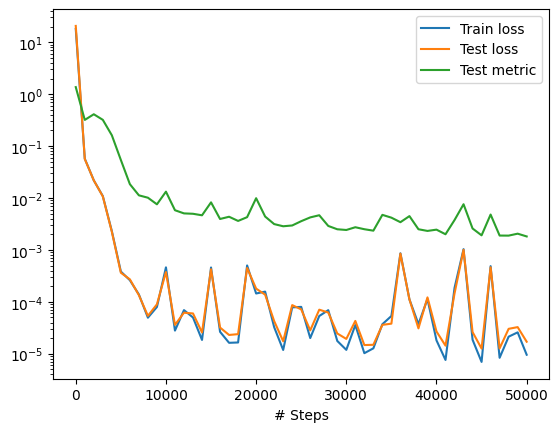

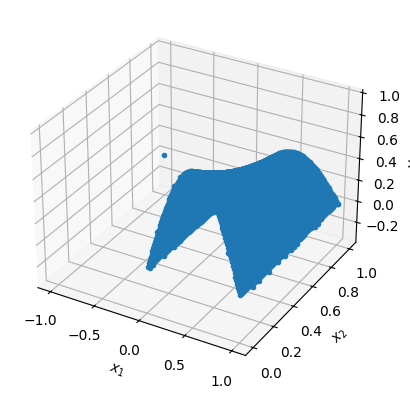

In [12]:
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

In [13]:
C

tensor(0.9999, requires_grad=True)